# Customer Lifetime Value Predictions

In this notebook a machine learning model will be built to predict Customer Lifetime Value (CLV) of an online retail store.

Data can be found here:
*https://www.kaggle.com/datasets/vijayuv/onlineretail*


Step-by-step process:

- Define an appropriate time frame for Customer Lifetime Value calculation
- Identify the features we are going to use to predict future value and create them
- Calculate lifetime value (LTV) for training the machine learning model
- Build and run the machine learning model
- Check if the model is useful

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, date

## Data Import

In [2]:
data = pd.read_csv("../data/OnlineRetail.csv",encoding= 'unicode_escape')

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
data.shape

(541909, 8)

## Data Cleaning

Cleaning data

### Missing Values

In [5]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
data.loc[data.CustomerID.isnull() == True].tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom
541540,581498,DOT,DOTCOM POSTAGE,1,12/9/2011 10:26,1714.17,NaN,United Kingdom


In [7]:
data.dropna(axis=0, inplace= True)

In [8]:
data.shape

(406829, 8)

### Duplicates

In [9]:
## assessing the nr. of duplicates in the dataset
data.duplicated().sum()

5225

In [10]:
data.loc[data.duplicated() == True].tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom
541701,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,1,12/9/2011 11:34,2.08,14446.0,United Kingdom


The rows which are denoted as duplicates are sufficiently dissimilar to be valid data entries, and are therefore kept in the data.

### Outliers

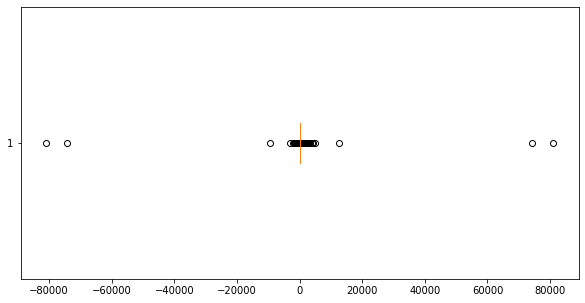

In [11]:
## Inspecting Outliers in Quantity
plt.figure(figsize= (10,5))
plt.boxplot(data.Quantity, vert= False);

In [12]:
## inspecting the orders with the highest quantity
data.sort_values(by="Quantity", ascending=False).head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom


As there is no Information regarding whether the orders are valid or not, they will be dropped, in order not to skew the rest of the data.

In [13]:
## dropping rows where Quantity is negative, as well as outliers in quantity
idx = data.loc[data.Quantity < 0].index

data.drop(idx, inplace= True)

idx = data.sort_values(by="Quantity", ascending=False).head(2).index

data.drop(idx, inplace= True)

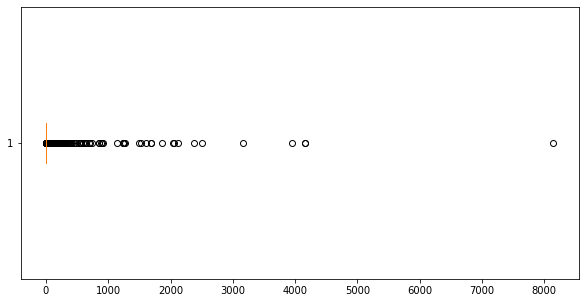

In [14]:
## Inspecting outliers in UnitPrice
plt.figure(figsize= (10,5))
plt.boxplot(data.UnitPrice, vert= False);

In [15]:
data.loc[data.UnitPrice == data.UnitPrice.max()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,5/3/2011 13:46,8142.75,16029.0,United Kingdom


As there is no information regarding validity of the unit prices, and they appear reasonable, they will be left in the data.

In [16]:
## changing InvoiceDate data type to datetime
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate)

In [17]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## Data Exploration

Exploring statistical trends and distributions

In [18]:
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [19]:
## showing a statistical summary of the distribution of Quantity
data.Quantity.describe()

count    397922.000000
mean         12.631837
std          47.263643
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       12540.000000
Name: Quantity, dtype: float64

In [20]:
## inspecting the amount of individual customers
print(f"\nThere are, in total, {len(data.CustomerID.unique())} customers.\n")


There are, in total, 4338 customers.



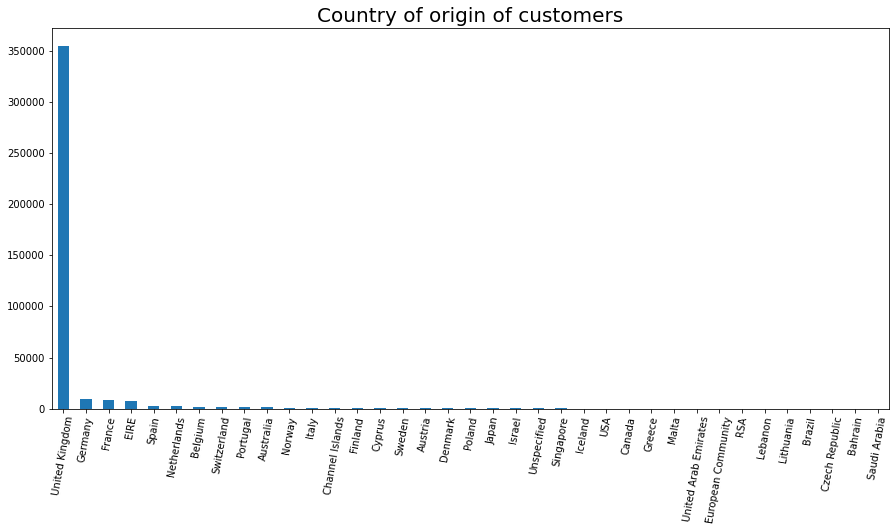

In [21]:
## inspecting country of origin of the customers
plt.figure(figsize=(15,7))
data.Country.value_counts().plot(kind="bar")
plt.title("Country of origin of customers", size=20)
plt.xticks(rotation=80);

In [22]:
## inspecting the timeframe of the dataset

earliest_date = data.InvoiceDate.min().date()
latest_date = data.InvoiceDate.max().date()

print(f"\nOrders in the dataset range from {earliest_date} to {latest_date}\n")


Orders in the dataset range from 2010-12-01 to 2011-12-09



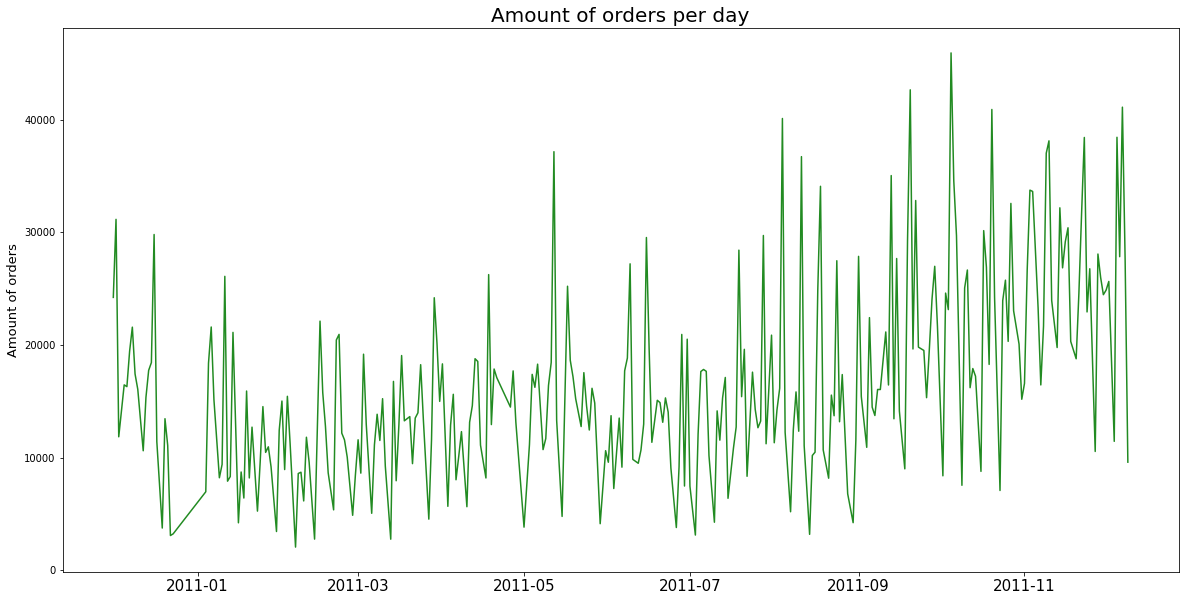

In [23]:
## inspecting amount of orders per day
date_df = data.copy()

date_df["date"] = date_df["InvoiceDate"].apply(lambda x: x.date())

date_df = pd.DataFrame(date_df.groupby("date")["Quantity"].sum()).reset_index().sort_values(by="date")

## plotting the distribution
plt.figure(figsize=(20,10))
plt.plot(date_df.date, date_df.Quantity, c= "forestgreen")
plt.title("Amount of orders per day", size=20)
plt.xticks(size=15)
plt.ylabel("Amount of orders", size=13);

### Calculating Revenue

In [24]:
## calculating revenue as sum of quantity and unit price per order
data["Revenue"] = data["Quantity"] * data["UnitPrice"]

## Customer Segmentation

This section segments customers into clusters based on Recency, Frequency and Monetary Value.

These features will then be used to forecast CLV.

In the first step, only the 3 months of data will be analysed and processed, which will then be used to predict the next 6 months.

In [25]:
data.InvoiceDate.describe()

/var/folders/2s/hl8h12kx35b4f1bh9818nxj00000gn/T/ipykernel_3591/1618497306.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.InvoiceDate.describe()


count                  397922
unique                  17284
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [26]:
## making 3 - months and 6 - months dataframes
data_3m = data[(data.InvoiceDate.dt.date < date(2011,6,1)) & (data.InvoiceDate.dt.date >= date(2011,3,1))].reset_index()
data_6m = data[(data.InvoiceDate.dt.date >= date(2011,6,1)) & (data.InvoiceDate.dt.date < date(2011,12,1))].reset_index()

### Calculating *Recency*

Finding out most recent purchase date for each customer, and see how many days they have been inactive for.

Afterwards, k-Means clustering will be applied to assign a *recency score*.

In [27]:
## creating a new dataframe using customer ID
user_df = pd.DataFrame(data_3m.CustomerID.unique(), columns= ["CustomerID"])

In [28]:
## get the latest purchase date for each customer and assign it to a new column
latest_purchase_df = pd.DataFrame(data_3m.groupby("CustomerID").InvoiceDate.max().reset_index())
latest_purchase_df.columns = ["CustomerID", "LatestPurchaseDate"]

In [29]:
## calculate difference between observation date (overall latest invoice date) 
## and latest invoice date per customer
latest_purchase_df["Recency"] = (data_3m.InvoiceDate.max() - latest_purchase_df["LatestPurchaseDate"]).dt.days

In [30]:
## merge the dataframe
recency_df = pd.merge(user_df, latest_purchase_df[["CustomerID", "Recency"]], on="CustomerID")

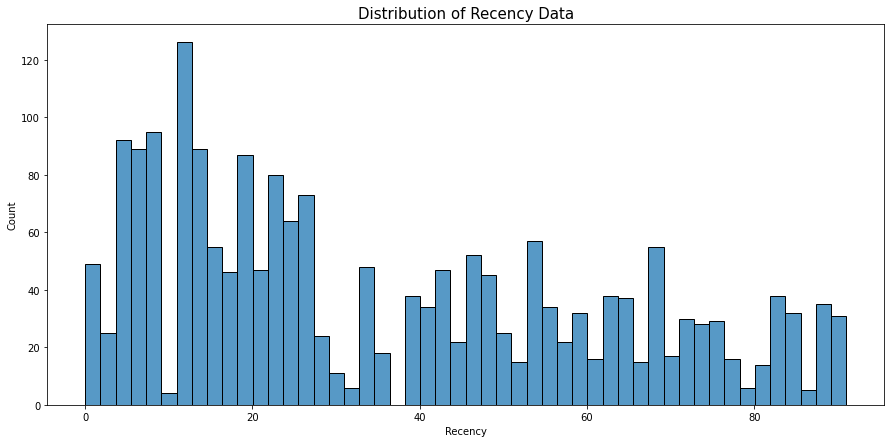

In [31]:
## plotting recency
plt.figure(figsize=(15,7))
sns.histplot(data=recency_df.Recency, bins=50)
plt.title("Distribution of Recency Data", size=15);

In [32]:
## statistical summary of recency data
recency_df.Recency.describe()

count    1993.000000
mean       35.801305
std        26.042012
min         0.000000
25%        13.000000
50%        27.000000
75%        56.000000
max        91.000000
Name: Recency, dtype: float64

In [33]:
## applying K-Means Clustering
from sklearn.cluster import KMeans

sse= {}
recency = recency_df[["Recency"]]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(recency)
    recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

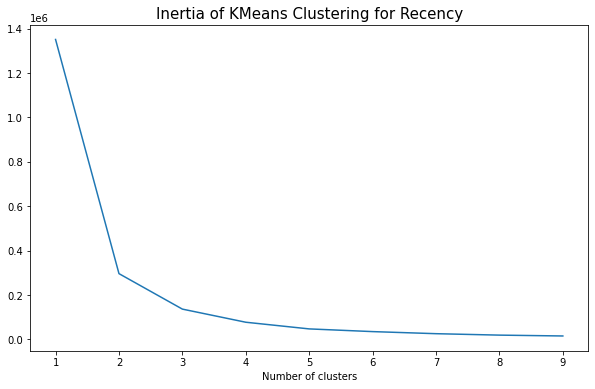

In [34]:
## plotting inertia to determine optimal nr. of clusters
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Recency", size=15);

According to the inertia graph, 3 appears to be the optimal number of clusters.

In [35]:
## assigning clusters to all customers in the dataset
kmeans = KMeans(n_clusters= 3)
kmeans.fit(recency_df[["Recency"]])
recency_df["RecencyCluster"] = kmeans.predict(recency_df[["Recency"]])

In [36]:
## function for ordering cluster numbers, to have an order based on "value"
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    
    new_cluster_field_name = 'new_' + cluster_field_name
    
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    
    df_new['index'] = df_new.index
    
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    
    df_final = df_final.drop([cluster_field_name],axis=1)
    
    df_final = df_final.rename(columns={"index":cluster_field_name})
    
    return df_final

In [37]:
## applying order_cluster() to recency_df
recency_df = order_cluster('RecencyCluster', 'Recency',recency_df,False)

In [38]:
## inspecting statistics for all clusters
recency_df.groupby("RecencyCluster")["Recency"].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,426.0,75.415493,9.001628,62.0,68.0,74.0,83.0,91.0
1,511.0,46.956947,8.103625,32.0,41.0,47.0,54.0,61.0
2,1056.0,14.422348,8.043462,0.0,8.0,14.0,21.0,30.0


In [39]:
recency_df.head()

,CustomerID,Recency,RecencyCluster
0,14620.0,13,2
1,14740.0,4,2
2,13880.0,25,2
3,17068.0,11,2
4,12971.0,4,2


In [40]:
## including recency data in user_df
user_df= pd.merge(user_df, recency_df, on= "CustomerID")

### Calculating Frequency

Find the total number of orders for each customer

In [41]:
## making dataframe with total number of orders per customer
frequency_df = data_3m.groupby("CustomerID").InvoiceDate.count().reset_index()
frequency_df.columns = ["CustomerID", "Frequency"]

frequency_df.head()

,CustomerID,Frequency
0,12347.0,24
1,12348.0,5
2,12352.0,23
3,12353.0,4
4,12354.0,58


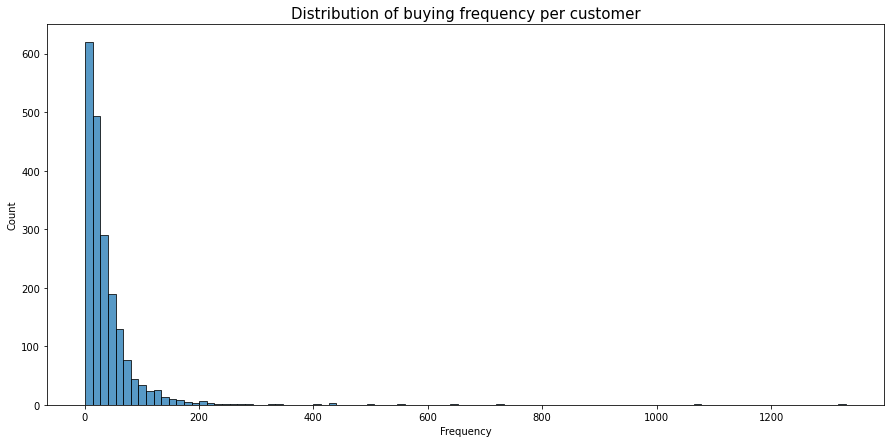

In [42]:
## plotting the distribution
plt.figure(figsize=(15,7))
sns.histplot(frequency_df["Frequency"], bins=100)
plt.title("Distribution of buying frequency per customer", size=15);

In [43]:
## applying frequency clusters

sse= {}
frequency = frequency_df[["Frequency"]]
for k in range(1,10):
    kmeans= KMeans(n_clusters= k, max_iter=1000).fit(frequency)
    frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

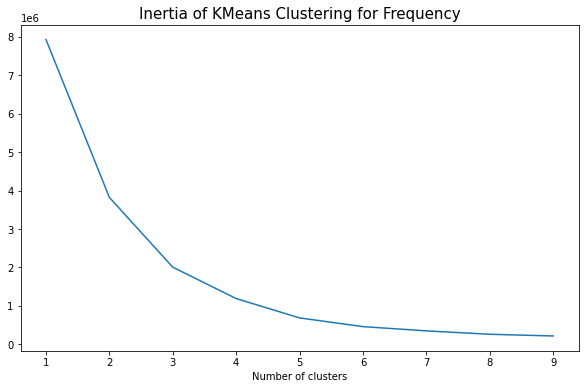

In [44]:
## plotting inertia
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Frequency", size=15);

It appears that the best number of clusters is 5.

In [45]:
## fitting the clusters to the customers
kmeans = KMeans(n_clusters= 5, max_iter=1000).fit(frequency_df[["Frequency"]])
frequency_df["FrequencyCluster"] = kmeans.predict(frequency_df[["Frequency"]])

In [46]:
frequency_df = order_cluster("FrequencyCluster", "Frequency", frequency_df, True)

In [47]:
## inspecting statistics for all clusters
frequency_df.groupby("FrequencyCluster")["Frequency"].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1379.0,17.148658,10.304737,1.0,9.0,16.0,24.00,39.0
1,490.0,61.032653,17.043639,40.0,47.0,57.0,72.00,105.0
2,110.0,149.863636,41.401032,106.0,118.5,135.0,168.25,282.0
3,12.0,474.666667,127.679523,328.0,391.0,436.0,558.25,730.0
4,2.0,1204.000000,179.605122,1077.0,1140.5,1204.0,1267.50,1331.0


In [48]:
## including frequency data in user_df
user_df= pd.merge(user_df, frequency_df, on= "CustomerID")

### Calculating Monetary Value

Clustering Customers based on Revenue.

In [49]:
## assessing total revenue per customer
revenue_df = data_3m.groupby("CustomerID")["Revenue"].sum().reset_index()

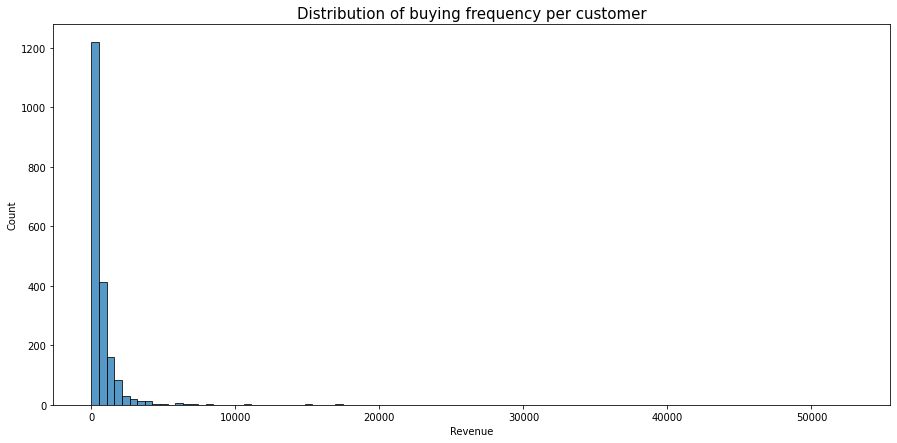

In [50]:
## plotting the revenue distribution
plt.figure(figsize=(15,7))
sns.histplot(revenue_df["Revenue"], bins=100)
plt.title("Distribution of buying frequency per customer", size=15);

In [51]:
## clustering based on revenue
sse = {}
revenue = revenue_df[["Revenue"]]
for k in range(1,10):
    kmeans= KMeans(n_clusters= k, max_iter= 1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

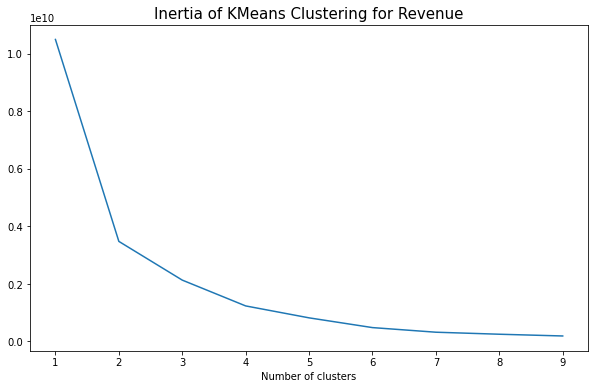

In [52]:
## plotting inertia
plt.figure(figsize=(10,6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.title("Inertia of KMeans Clustering for Revenue", size=15);

Based on the inertia plot, the optimal number of clusters is 5.

In [53]:
## clustering customers based on revenue
kmeans = KMeans(n_clusters= 5, max_iter= 1000)
kmeans.fit(revenue_df[["Revenue"]])

revenue_df["RevenueCluster"] = kmeans.predict(revenue_df[["Revenue"]])

revenue_df = order_cluster("RevenueCluster", "Revenue", revenue_df, True)

In [54]:
## inspecting descriptive statistics for all revenue clusters
revenue_df.groupby("RevenueCluster")["Revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1684.0,415.442280,275.802105,2.90,203.9300,336.545,572.0625,1193.88
1,270.0,1981.387670,775.833113,1199.25,1438.9250,1703.820,2273.9725,4514.24
2,25.0,7387.236800,2060.013397,4867.90,6249.7600,6764.490,8051.5900,12382.32
3,12.0,19673.080833,4759.985868,14984.73,16672.6275,17564.915,22267.2200,29768.00
4,2.0,43979.160000,12541.161018,35111.22,39545.1900,43979.160,48413.1300,52847.10


In [55]:
## including revenue data in user_df
user_df= pd.merge(user_df, revenue_df, on= "CustomerID")

### Making final dataframe

In [56]:
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,13,2,26,0,412.78,0
1,14740.0,4,2,89,1,1448.21,1
2,13880.0,25,2,38,0,718.63,0
3,16462.0,91,0,1,0,34.00,0
4,17068.0,11,2,76,1,1480.95,1


In [57]:
## applying over all scoring by adding cluster numbers
user_df["OverallScore"] = user_df["RecencyCluster"] + user_df["FrequencyCluster"] + user_df["RevenueCluster"]

In [58]:
## creating the final dataframe
user_df.groupby("OverallScore")["Recency", "Frequency", "Revenue"].mean()

/var/folders/2s/hl8h12kx35b4f1bh9818nxj00000gn/T/ipykernel_3591/3038707750.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_df.groupby("OverallScore")["Recency", "Frequency", "Revenue"].mean()


,Recency,Frequency,Revenue
OverallScore,,,
0,75.845930,14.648256,287.563808
1,50.916115,21.849890,375.628940
2,21.106259,24.755459,468.546798
3,17.706107,54.156489,938.286069
4,13.401316,84.236842,2097.585855
5,11.600000,138.000000,3306.266300
6,8.750000,308.500000,8256.879167
7,7.750000,271.750000,17746.262500
8,10.333333,754.333333,12619.533333


In [59]:
## binning the clusters into classes
user_df["Segment"] = 'Low-Value'
user_df["Segment"].loc[user_df.OverallScore>3] = "Mid-Value"
user_df["Segment"].loc[user_df.OverallScore>6] = "High-Value"

/Users/garritwilson/.pyenv/versions/3.8.12/envs/li-monitoring/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [60]:
## inspecting the final dataframe
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,13,2,26,0,412.78,0,2,Low-Value
1,14740.0,4,2,89,1,1448.21,1,4,Mid-Value
2,13880.0,25,2,38,0,718.63,0,2,Low-Value
3,16462.0,91,0,1,0,34.00,0,0,Low-Value
4,17068.0,11,2,76,1,1480.95,1,4,Mid-Value


### Calculating 6-months lifetime value (LTV)

The 6-months LTV is going to be used for training the machine learning algorithm.

As this is going to be a supervised learning task, the RFM features that have just been created will be used to predict the 6-months LTV, which will be calculated next.

In [61]:
## making the 6m user dataframe with the sum of revenue generated per customer
user_df_6m = data_6m.groupby("CustomerID")["Revenue"].sum().reset_index()
user_df_6m.columns = ["CustomerID", "6m_Revenue"]

<AxesSubplot:xlabel='6m_Revenue', ylabel='Count'>

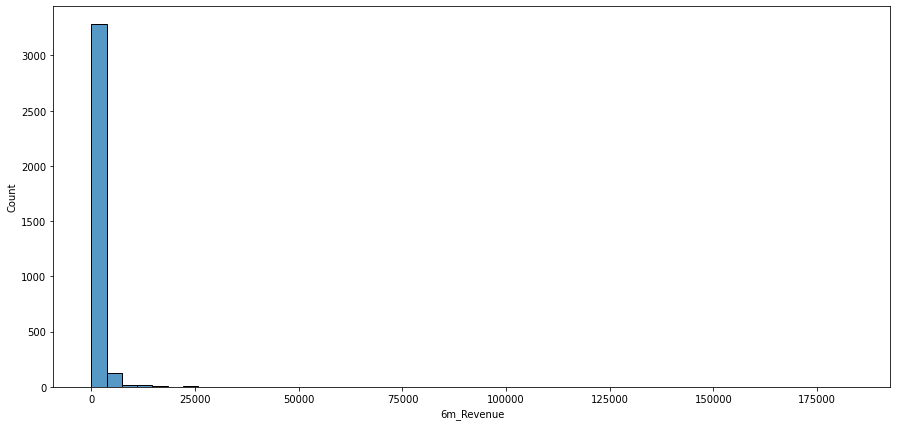

In [62]:
## visualizing the distribution of revenue per customer
plt.figure(figsize=(15,7))
sns.histplot(user_df_6m["6m_Revenue"], bins= 50)

In [63]:
## merging 6-months and 3-months dataframes
df_merged = pd.merge(user_df, user_df_6m, on="CustomerID", how='left')
df_merged.shape

(1993, 10)

In [66]:
## as there are nan-values in the dataset, they will be dropped
df_merged.dropna(inplace=True)
df_merged.shape

In [68]:
df_merged["6m_Revenue"].describe()

count      1501.000000
mean       2351.328508
std        8799.158498
min           7.500000
25%         408.000000
50%         940.830000
75%        1924.980000
max      183529.650000
Name: 6m_Revenue, dtype: float64

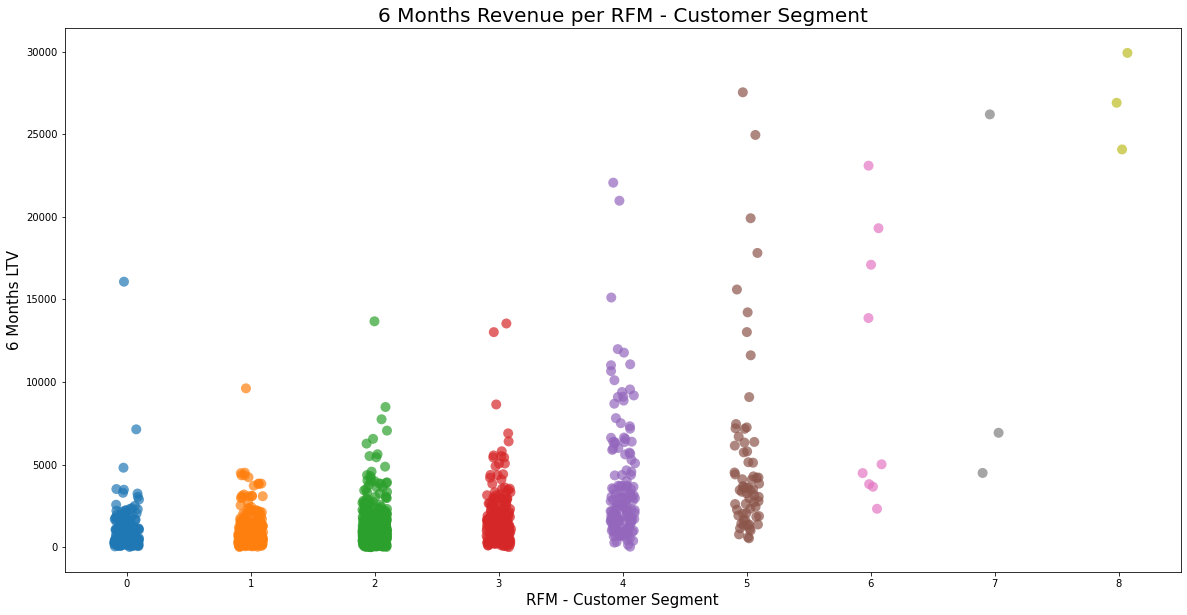

In [83]:
## plotting 6 mon
df_graph = df_merged.loc[df_merged["6m_Revenue"] < 30000]

plt.figure(figsize=(20,10))
sns.stripplot(data= df_graph,
                 x= df_graph["OverallScore"],
                 y= df_graph["6m_Revenue"],
                 size=10,
                 alpha= 0.7)

plt.title("6 Months Revenue per RFM - Customer Segment", size= 20)
plt.ylabel("6 Months LTV", size= 15)
plt.xlabel("RFM - Customer Segment", size= 15);